# Master MVA, examen du cours EDPs numériques pour le traitement de l'image. 

## 0. Import des libraries requises 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 1. Schéma linéaire

In [2]:
aX,dx = np.linspace(-1,1,51,retstep=True) # intervalle [-1,1], 51 points de discrétisation
X0,X1 = np.meshgrid(aX,aX,indexing='ij') # Coordonnées dans le domaine [-1,1]^2
dΩ = X0**2+X1**2>=0.9**2 # 'Bord' du domaine discrétisé

In [3]:
c = 1. # Cout c(x) constant
w = np.array([1,np.sqrt(3)])/2 # Direction de différentiation

L'opérateur de Jacobi correspondant au schéma linéaire, est noté dans l'énoncé
$$
    \Lambda_h^w u(x)
$$




*Question 1*
===
Implémenter cet opérateur.


In [ ]:
def Λlin(u,w,c,dx,dΩ):
    u0m = np.roll(u, 1,axis=0); u0m[ 0,:] = np.inf # u(x-dx*e0)
    u0p = np.roll(u,-1,axis=0); u0p[-1,:] = np.inf # u(x+dx*e0)
    u1m = np.roll(u, 1,axis=1); u1m[:, 0] = np.inf # u(x-dx*e1)
    u1p = np.roll(u,-1,axis=1); u1p[:,-1] = np.inf # u(x+dx*e1)
    
    #TODO

    return np.where(dΩ,
    #TODO, # Valeur de la mise à jour sur le bord
    #TODO) # Valeur de la mise à jour dans l'intérieur


Nous itérons l'opérateur de mise à jour, et vérifions visuellement les résultats.

In [5]:
u = np.zeros_like(X0)
for i in range(100): u = Λlin(u,w,c,dx,dΩ)

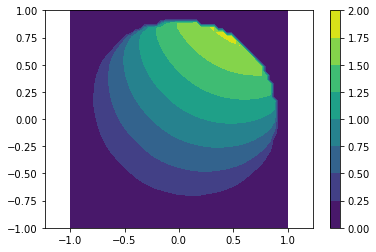

In [6]:
plt.contourf(X0,X1,u); 
plt.axis('equal')
plt.colorbar();

Le schéma linéaire est noté dans l'énoncé
$$
    F_h^w u(x).
$$





*Question 2*
===
Implémenter ce schéma.


In [ ]:
def Flin(u,w,c,dx,dΩ):
    u0m = np.roll(u, 1,axis=0); u0m[ 0,:] = np.inf # u(x-dx*e0)
    u0p = np.roll(u,-1,axis=0); u0p[-1,:] = np.inf # u(x+dx*e0)
    u1m = np.roll(u, 1,axis=1); u1m[:, 0] = np.inf # u(x-dx*e1)
    u1p = np.roll(u,-1,axis=1); u1p[:,-1] = np.inf # u(x+dx*e1)
    
    # TODO
    
    return np.where(dΩ,
                    #TODO, #Valeur du schéma sur le bord
                    #TODO) #Valeur du schéma dans l'intérieur


In [8]:
# plt.contourf(X0,X1,Flin(u,w,c,dx,dΩ)); plt.colorbar(); # DEBUG

Validation croisée du schéma et de l'opérateur de mise à jour.

In [9]:
assert np.allclose(Flin(u,w,c,dx,dΩ),0)

## 2. Equation eikonale sous forme de Bellman

In [10]:
ws = np.array([[1,0],[-1/2,np.sqrt(3)/2],[-1/2,-np.sqrt(3)/2]]) # Directions définissant la norme cristalline

L'opérateur de mise à jour correspondant au schéma non-linéaire est noté dans l'énoncé
$$
    \Lambda_h u(x).
$$




*Question 3*
===
Implémenter ce schéma.


In [ ]:
def Λ(u,ws,c,dx,dΩ):
    return # TODO


In [12]:
u = np.zeros_like(X0)
for i in range(100): u = Λ(u,ws,c,dx,dΩ)

/var/folders/my/8txl5p_52rj9jc_601wqr7cr0000gn/T/ipykernel_49064/2338611534.py:11: RuntimeWarning: invalid value encountered in multiply
  return np.where(dΩ,0,(ρ0*u0+ρ1*u1+dx*c)/(ρ0+ρ1))


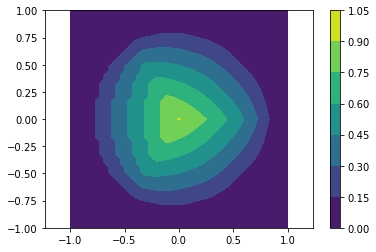

In [13]:
plt.contourf(X0,X1,u); 
plt.axis('equal')
plt.colorbar();

Le schéma non-linéaire est noté dans l'énoncé
$$
    F_h u(x).
$$




*Question 4*
===
Implémenter ce schéma.


In [ ]:
def F(u,ws,c,dx,dΩ):
    return # TODO


In [15]:
# plt.contourf(X0,X1,F(u,ws,c,dx,dΩ)); plt.colorbar() # DEBUG

In [16]:
assert np.allclose(F(u,ws,c,dx,dΩ), 0)

/var/folders/my/8txl5p_52rj9jc_601wqr7cr0000gn/T/ipykernel_49064/2827219335.py:11: RuntimeWarning: invalid value encountered in multiply
  return np.where(dΩ,u,ρ0*(u-u0)/dx+ρ1*(u-u1)/dx - c)


## 3. Algorithme forward-backward et LASSO

La méthode du LASSO en statistiques définit une "inversion matricielle", approchée, stabilisée de manière non-linéaire, promouvant les solutions creuses (avec peu de coefficients non-nuls). Elle est définie par le problème d'optimisation:
$$
    \mathrm{argmin}_{x} \frac 1 2 \|Ax-y\|^2 + \lambda \|x\|_1
$$

Nous l'illustrons en reconstituant un vecteur creux de grande dimension à l'aide de quelques mesures dans le domaine fréquentiel.

In [17]:
np.random.seed(42)

# Créons un vecteur de grande dimension, ayant peu de composantes non-nulles.
N = 200  # Dimension de x
Nnz = 10 # Nombre de composantes non-zeros
x_source = np.zeros(N)
for i in range(Nnz): 
    x_source[np.random.randint(N)] = np.random.uniform(-1,1)

# Créons une matrice de mesures observant quelques modes fréquentiels
M = 50 # Dimension de l'espace d'observations
ωs = 2*np.pi*np.random.randint(N,size=M)/N # Fréquences
ϕs = np.random.uniform(0,2*np.pi,size=M) # Déphasages
A = np.array([[np.cos(ω*x+ϕ) for x in range(N)] for ω,ϕ in zip(ωs,ϕs)])
L = np.linalg.norm(A)**2 # Constante de Lipschitz de grad g

# Vecteur d'observations, (légèrement) bruité
ϵ = 0.005
y = np.dot(A,x_source) + ϵ*np.random.normal(M)

In [18]:
def objective(A,y,λ,x):
    return 0.5*np.sum( (np.dot(A,x)-y)**2 )+λ*np.sum(np.abs(x))

L'opérateur proximal associé à la norme $l^1$ est défini par 
$$
    \mathrm{prox}_{\alpha l^1}(x) = \mathrm{argmin}_{z \in R^N} \frac 1 2 \|z-x\|^2 + \alpha \|x\|_1.
$$




*Question 5*
===
Implémenter cet opérateur. On pourra utiliser l'expression explicite de la solution du problème d'optimisation, obtenue dans l'énoncé.


In [ ]:
def proxl1(x,α):
    return # TODO


Le résidu associé à une équation linéaire 
$$
    g(x) = \frac 1 2 \|Ax-y\|^2
$$
admet un gradient explicite
$$
    \nabla g(x) = A^T A x - A^T y.
$$




*Question 6*
===
Implémenter ce gradient.


In [20]:
def gradres(A,y,x):
    # Gradient of (1/2) \|Ax-y\|^2 as a function of x.
    return np.dot(A.T,np.dot(A,x)-y)

Chaque étape de l'algorithme forward backward, pour la minimisation d'une somme de deux fonctions, correspond à pas de temps semi-implicite de la discrétisation de $\partial_t x = -\nabla f(x) - \nabla g(x)$. Il s'écrit:
$$
    x_{k+1} = \mathrm{prox}_{\tau f} (x-\tau \nabla g(x)).
$$
Dans le cas du LASSO, on choisit $f(x) = \lambda \|x\|_1$ et $g(x) = (1/2) \|Ax-y\|^2$.




*Question 7*
===
Implémenter le pas de temps ci-dessus.


In [ ]:
def FBstep(A,y,λ,τ,x):
    return #TODO


In [22]:
λ=3; τ=1/L
x = np.zeros(N)
obj = []
for i in range(2000):
    obj.append(objective(A,y,λ,x))
    x=FBstep(A,y,λ,τ,x)

La fonction objectif décroit au cours des itérations, ce qui constitue un test de validation.

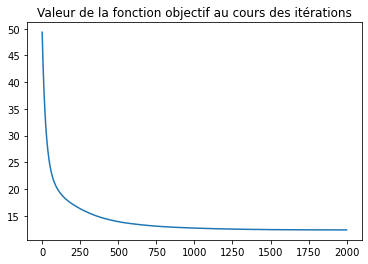

In [23]:
plt.title("Valeur de la fonction objectif au cours des itérations")
plt.plot(obj);

In [24]:
obj=np.array(obj)
assert np.all(obj[:-1]-obj[1:]>=0)

Noter que la source n'est *pas* reconstruite de manière exacte, seulement *approchée* : on retrouve les pics principaux.


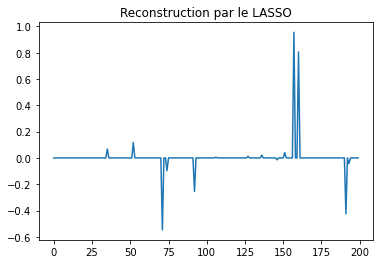

In [25]:
plt.title("Reconstruction par le LASSO")
plt.plot(x);

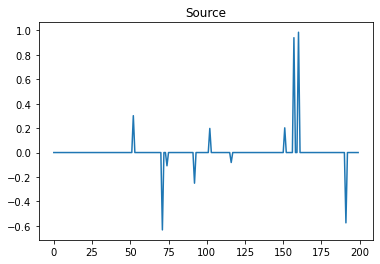

In [26]:
plt.title("Source")
plt.plot(x_source);

La valeur de la fonction objectif associée à la reconstruction est plus petite que celle de la source.

In [27]:
assert objective(A,y,λ,x) <= objective(A,y,λ,x_source)